# Collaborative-Filter w/ Deep Learning

In [1]:
from fastai.learner import *
from fastai.column_data import *

In [2]:
# Data
path='data/ml-latest-small/'

In [3]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
movies = pd.read_csv(path+'movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


# Embeddings (Matrix Factorization Model)
- EmbeddingsDot

In [5]:
val_idxs = get_cv_idxs(len(ratings)) # default 20% of dataset, see get_cv_idx in dataset.py
wd=2e-4  # weight decay, will talk about later, L2 regularization
n_factors = 50  # how big is embedding matrix, dimensionality of embeddings matrix

In [6]:
# userid and movieid, may not be contiguous (skip numbers, start at 1 million, skip ...)
# we will need to make them contiguous our embeddings matrix will be unnecesarily large

# first thing is mapping from every userid to a contiguoius integer, u_uniq
# get a list of 
# dictionalry mapping, user2idx, { } u_unique to unique index super handy
#   often need to do it in ML, study it!
# replace userid column with the userid index
# pandas.apply applies arbitrary function, created on the fly with lambda
# do the same thing for movies
# same matrices before but now has contiguous index

# add unique index for users
u_uniq = ratings.userId.unique()
user2idx = {o:i for i,o in enumerate(u_uniq)}  # object:index
ratings.userId = ratings.userId.apply(lambda x: user2idx[x]) # returns the index

# add unique index for ratings
m_uniq = ratings.movieId.unique()
movie2idx = {o:i for i,o in enumerate(m_uniq)}
ratings.movieId = ratings.movieId.apply(lambda x: movie2idx[x]) # returns the index

# count of users and movies
n_users=int(ratings.userId.nunique())   
n_movies=int(ratings.movieId.nunique())

In [9]:
# two embedding matrices  and lookup our users and movies (items) in the matrices
class CFMF(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_movies, n_factors)
        self.u.weight.data.uniform_(0,0.05)
        self.m.weight.data.uniform_(0,0.05)

        # use same Columnar model data as we used for Rossman
        #  has continuous and categorical varials (there are no categorical)
        #  leverage the columnar data model 
        #   user mini bartch will be [0] 0th column
        #   movie mini batch will be [1] 1st column
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        u,m = self.u(users),self.m(movies) # lookup users and movies .. user id numbered value
                                          #  PyTorch can lookup a mini-batch at a time
                                          # if we did this manually, would not get GPU accel
        return (u*m).sum(1).view(-1, 1)   # here's the dot product
    
 #      return (u*m).sum(1)  # Hiromi return function, "medium" ... slightly different
    

In [7]:
#  create independent and dependent variables
x = ratings.drop(['rating', 'timestamp'],axis=1)
y = ratings['rating'].astype(np.float32)

# this is the same as we used for Rossman, ColumnarModelData as we used previous 
#   this is the only fastai module, not interesting enough to do details ... 
data = ColumnarModelData.from_data_frame(path, val_idxs, x, y, ['userId', 'movieId'], 64)

In [10]:

model = CFMF(n_users,n_movies).cuda()
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9)


In [11]:
# these nunbers lookign better, down to 0.83, getting close

fit(model, data, 10, opt, F.mse_loss)

epoch      trn_loss   val_loss                                 
    0      1.739987   1.797832  
    1      1.303684   1.514445                                 
    2      1.181558   1.461555                                 
    3      1.073532   1.438749                                 
    4      1.036666   1.42922                                   
    5      0.937269   1.438685                                  
    6      0.892375   1.440813                                  
    7      0.794129   1.440274                                  
    8      0.762279   1.436446                                  
    9      0.755305   1.450189                                  



[array([1.45019])]

# NN w/ PyTorch (Custom Layer on Top of PyTorch)
without day of week

In [11]:
# Thus just makes the code a little better and return the embeddings
def get_emb(ni,nf):
    e = nn.Embedding(ni, nf)
    e.weight.data.uniform_(-0.01,0.01)
    return e

# nh - number of hidden units
# NN Advantages
# NN approach to collaborative filtering
#  choose number hidden layers, RELU, dropout 
#   
class EmbeddingNet(nn.Module):
    def __init__(self, n_users, n_movies, nh=10, p1=0.05, p2=0.5,):
        super().__init__()
        # create embeddings 
        (self.u, self.m) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors)]]
        # create linear layer, created by nn.Linear
        #   in ML learn how to do Linear layer from scratch
        # create two linear layers ... originally just did 2
        # could create a loop here to create more layers
        self.lin1 = nn.Linear(n_factors*2, nh)
        # this many activations means, linear layer colunms (nh in lin2)
        self.lin2 = nn.Linear(nh, 1)
        self.drop1 = nn.Dropout(p1)
        self.drop2 = nn.Dropout(p2)
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        # user and movies embeddings concat on first dimension, torch
        #  we will come back to drop out
        x = self.drop1(torch.cat([self.u(users),self.m(movies)], dim=1))
        #  goes through linear layer and then one activation
        #  go through Relu ... functions inside F
        x = self.drop2(F.relu(self.lin1(x)))
        # return sigmoid ... all functions inside F
        return F.sigmoid(self.lin2(x)) * (max_rating-min_rating+1) + min_rating-0.5
    
    # this is genuine NN, though not very deep, 1 hidden layer

In [12]:
min_rating,max_rating = ratings.rating.min(),ratings.rating.max()
min_rating,max_rating

# now construct the NN, pass to cuda (GPU), difin
# all functions
wd=1e-5
model = EmbeddingNet(n_users, n_movies).cuda()
opt = optim.Adam(model.parameters(), 1e-2, weight_decay=wd)

In [13]:
# these nunbers lookign better, down to 0.83, getting close
fit(model, data, 5, opt, F.mse_loss)

epoch      trn_loss   val_loss                                  
    0      0.850864   0.803234  
    1      0.81824    0.793927                                  
    2      0.833568   0.786462                                  
    3      0.781164   0.783997                                  
    4      0.742855   0.781403                                  
    5      0.788319   0.780822                                  
    6      0.778614   0.790607                                  
    7      0.806005   0.77452                                   
    8      0.779248   0.77425                                   
    9      0.746672   0.77981                                   



[array([0.77981])]

# EmbeddingNet2 w/ Day of week as an Input

In [241]:
# Thus just makes the code a little better and return the embeddings
def get_emb(ni,nf):
    e = nn.Embedding(ni, nf)
    e.weight.data.uniform_(-0.01,0.01)
    return e

class EmbeddingNet2(nn.Module):
    def __init__(self, n_users, n_movies, n_days, nfu, nfm, nfd, 
                nh = [10], drops = [.1, .5]):
        super().__init__()
        # create embeddings 
        (self.u, self.m, self.d) = [get_emb(*o) for o in [
            (n_users, nfu), (n_movies, nfm), (n_days, nfd)]]
        # default to 1 hidden layer
        # drops correspond to hidden layer + output layer
      
        self.lin1 = nn.Linear(nfu + nfm + nfd, nh[0])
        self.emb_drop = nn.Dropout(drops[0])

        self.lins = nn.ModuleList([
            nn.Linear(nh[i], nh[i+1]) for i in range(len(nh)-1)])

        for drop in drops:
            self.drops = nn.ModuleList([nn.Dropout(drop) for drop in drops])
            
        self.lastdrop=nn.Dropout(drops[len(drops)-1])
        self.lastlin=nn.Linear(nh[len(nh)-1],1)


        
    def forward(self, cats, conts):
        users,movies,days = cats[:,0],cats[:,1],cats[:,2]
        # user and movies embeddings concat on first dimension, torch
        #  we will come back to drop out
        #  goes through linear layer and then activation
        #  go through Relu ... functions inside F
        # return sigmoid ... all functions inside F
        x = self.emb_drop(torch.cat([self.u(users),self.m(movies),self.d(days)], dim=1))
        x = F.relu(self.lin1(x))
        for l,d, in zip(self.lins, self.drops):
            x = d(x)
            x = l(x)
            x = F.relu(x)
        x=self.lastdrop(x)
        x=self.lastlin(x)
        return F.sigmoid(x) * (max_rating-min_rating+1) + min_rating-0.5
    
  

In [242]:
from datetime import datetime
ep_to_day_lambda = lambda x:datetime.fromtimestamp(x/1000).strftime("%A")

print(ratings.size)

#ratings2=ratings.copy()

ratings['day']=ratings['timestamp'].apply(ep_to_day_lambda)
ratings[['userId', 'movieId', 'rating',  'day', 'timestamp']].head()

504180


,userId,movieId,rating,day,timestamp
0,0,0,4.0,Sunday,964982703
1,0,1,4.0,Sunday,964981247
2,0,2,4.0,Sunday,964982224
3,0,3,5.0,Sunday,964983815
4,0,4,5.0,Sunday,964982931


day percentiles:


Sunday       0.239151
Saturday     0.222996
Wednesday    0.140763
Monday       0.131947
Tuesday      0.108791
Thursday     0.082352
Friday       0.074001
Name: day, dtype: float64

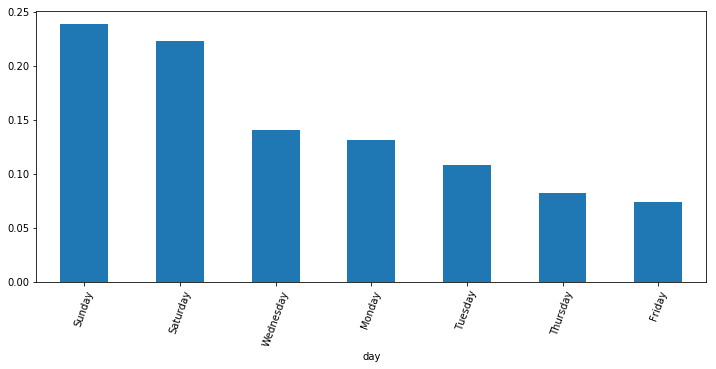

In [243]:
# Day Percentiles
#   movie watching by day of the week
print("day percentiles:")
display(ratings['day'].value_counts()/len(ratings))

#.plot(kind='bar',subplots=True, layout=(1,2), figsize=[18,3],rot=70)
(ratings.groupby('day')['day'].count()/len(ratings)).sort_values( 
    ascending = False).plot(kind='bar', rot=70, figsize=[12,5])

In [244]:
# add unique index for days
day_uniq = ratings.day.unique()
day2idx = {o:i for i,o in enumerate(day_uniq)}  # object:index
ratings.day = ratings.day.apply(lambda x: day2idx[x]) # returns the index
n_days=int(ratings.day.nunique())

print(n_users, n_movies, n_days)

610 9724 7


In [245]:
from sklearn.model_selection import StratifiedShuffleSplit
category='day'
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.8, random_state = 42) 

for val_idxs, _ in split.split(ratings, ratings[category]): 
    df_val = ratings.iloc[val_idxs].copy()   # don't really need this part
print(len(val_idxs))
val_idxs

20167


array([84149, 33458, 72054, ..., 37637, 91598, 19940])

In [246]:
min_rating,max_rating = ratings.rating.min(),ratings.rating.max()
min_rating,max_rating
wd=2e-4  # weight decay, will talk about later, L2 regularization
nfu = 50 #  dimensionality of embeddings matrix
nfm = 50  
nfd = 4
print(len(val_idxs))
val_idxs

20167


array([84149, 33458, 72054, ..., 37637, 91598, 19940])

In [247]:
#  create independent and dependent variables

x = ratings.drop(['rating', 'timestamp'],axis=1)
y = ratings['rating'].astype(np.float32)

# this is the same as we used for Rossman, ColumnarModelData as we used previous 
#   this is the only fastai module, not interesting enough to do details ... 
data = ColumnarModelData.from_data_frame(path, val_idxs, x, y, ['userId', 'movieId','day'], 64)

In [248]:
# .cuda to put it on GPU
wd=2e-4
#model = EmbeddingNet2(cf.n_users, cf.n_items).cuda()
model = EmbeddingNet2(n_users, n_movies,n_days,nfu,nfm,nfd, nh=[30], 
                       drops = [0.05, 0.5]).cuda()
#opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9)
opt = optim.Adam(model.parameters(), 1e-3, weight_decay=wd)

In [249]:
# these nunbers lookign better, down to 0.83, getting close
fit(model, data, 5, opt, F.mse_loss)

epoch      trn_loss   val_loss                                  
    0      0.77158    0.771764  
    1      0.763405   0.750387                                  
    2      0.73818    0.747482                                  
    3      0.749548   0.741922                                  
    4      0.735191   0.748893                                  


[array([0.74889])]

In [239]:
model = EmbeddingNet2(n_users, n_movies,n_days,nfu,nfm,nfd, nh=[50, 30], 
                       drops = [ .05, .2, .5]).cuda()
opt = optim.Adam(model.parameters(), 1e-3, weight_decay=wd)

In [240]:
# these nunbers lookign better, down to 0.83, getting close
fit(model, data, 5, opt, F.mse_loss)

epoch      trn_loss   val_loss                                  
    0      0.794924   0.76525   
    1      0.786284   0.746976                                  
    2      0.74575    0.735508                                  
    3      0.720929   0.736082                                  
    4      0.70611    0.735818                                  


[array([0.73582])]

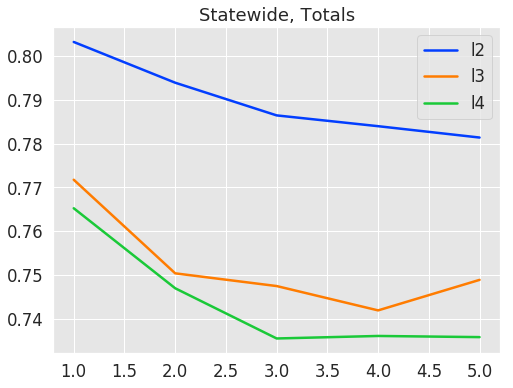

In [67]:
%matplotlib inline
import seaborn as sns  
import matplotlib.pyplot as plt


color = sns.color_palette()
sns.set_palette("bright")  # bright colors
sns.set_style("ticks")
sns.set_style("darkgrid",  {"axes.facecolor": ".9"}) # grey background with grid

#plt.rcParams['axes.labelsize'] = 14
#plt.rcParams['xtick.labelsize'] = 12
#plt.rcParams['ytick.labelsize'] = 12
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

fig, axes = plt.subplots(figsize=(8,6), nrows=1, ncols=1)

l1 =[ 1.80665 , 1.503765 ,  1.45577 ,1.435211 , 1.441418 ]
l2 = [0.803234 ,  0.793927  , 0.786462   , 0.783997 ,  0.781403 ]
l3 =[0.771764, 0.750387  ,  0.747482  , 0.741922  ,  0.748893 ]
l4 = [0.76525 ,0.746976 , 0.735508 , 0.736082 , 0.735818 ]
dashes=['-','-']

data = {'l2': l2, 'l3': l3, 'l4': l4}
df = pd.DataFrame( data,index=[1,2,3,4,5])

ax1 = sns.lineplot(data=df, dashes=False, hue=df.l2)


#ax1=ppv_by_county1[['Statewide']].sort_values(ascending= False).sort_index(level='year', 
#                        sort_remaining=False).plot(ax=axes[0,0],kind='bar', rot=60)

ax1.title.set_text('Statewide, Totals')
#fig.subplots_adjust(hspace=.5)
#plt.show()

# Join Plot

In [34]:
%matplotlib inline
y=learn.data.val_y
sns.jointplot(preds, y, kind='hex', stat_func=None);

NameError: name 'preds' is not defined